<h1 style="text-align:center; color:black;">Comparative Analysis of ARIMA and Prophet Models</h1>

## Work Overview

This notebook covers the following topics:

- Data Loading
- Data Exploration
- ARIMA Model
- Prophet Model

### Importing Packages and Loading data

In [273]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_squared_error , mean_absolute_error,r2_score
import itertools
from sklearn.preprocessing import MinMaxScaler
import itertools
import warnings
warnings.filterwarnings('ignore')

In [274]:
data = pd.read_csv('simple.csv')

In [275]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    397 non-null    object 
 1   Value   397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [276]:
data['DATE']=pd.to_datetime(data['DATE'])

In [277]:
data.set_index('DATE', inplace=True)

In [278]:
data.head()

,Value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


### EDA

In [279]:
# Statitical Measurements
print(data.describe())

            Value
count  397.000000
mean    88.847218
std     15.387834
min     55.315100
25%     77.105200
50%     89.779500
75%    100.524400
max    129.404800


In [280]:
# Checking missing values
print(data.isnull().sum())

Value    0
dtype: int64


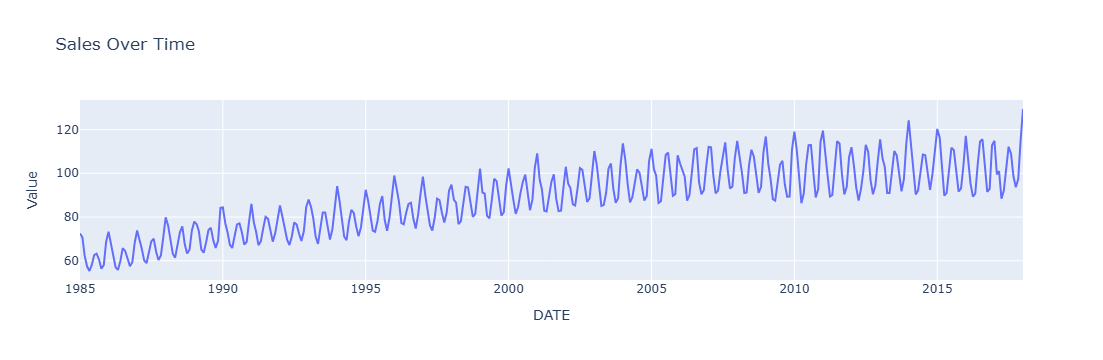

In [299]:
fig = px.line(data, x=data.index, y='Value', title='Sales Over Time')
fig.show()

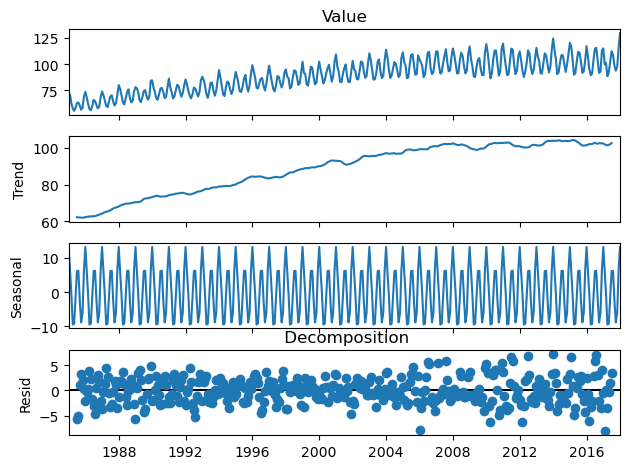

In [282]:
decomposition = seasonal_decompose(data['Value'], model='additive')
decomposition.plot()
plt.title(' Decomposition')
plt.show()

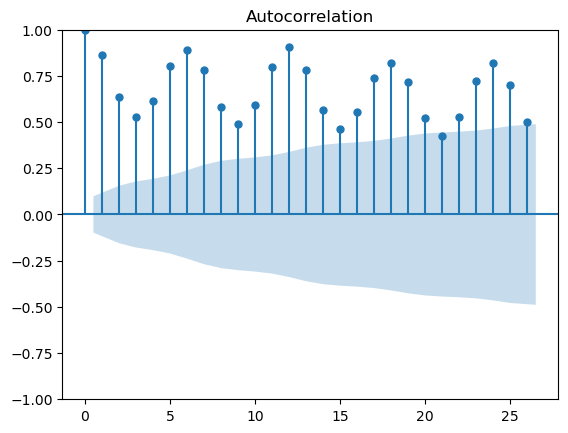

In [283]:
acf = plot_acf(data['Value'])

In [284]:
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

### ARIMA Model

In [285]:
best_model = ARIMA(train['Value'], order=(2,1,2))
model_fit = best_model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  317
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -819.524
Date:                Fri, 26 Jul 2024   AIC                           1649.047
Time:                        06:20:33   BIC                           1667.826
Sample:                    01-01-1985   HQIC                          1656.549
                         - 05-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9983      0.002    530.333      0.000       0.995       1.002
ar.L2         -0.9994      0.001   -825.959      0.000      -1.002      -0.997
ma.L1         -1.0624      0.068    -15.683      0.0

In [288]:
best_model = ARIMA(train['Value'], order=(2,1,2)).fit()
train_pred = best_model.predict(start=train.index[0], end=train.index[-1])
test_pred = best_model.predict(start=test.index[0], end=test.index[-1])
forecast_steps = 100  
forecast_object = best_model.get_forecast(steps=forecast_steps)
forecast = forecast_object.predicted_mean
forecast_index = pd.date_range(start=test.index[-1], periods=forecast_steps+1, freq='M')[1:]

In [289]:
# Evaluate the model on training set
train_mse = mean_squared_error(train['Value'], train_pred)
train_rmse = np.sqrt(train_mse)
print(f'Training RMSE: {train_rmse}')

# Evaluate the model on testing set
test_mse = mean_squared_error(test['Value'], test_pred)
test_rmse = np.sqrt(test_mse)
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 5.193014052346426
Testing RMSE: 7.0266767094527705


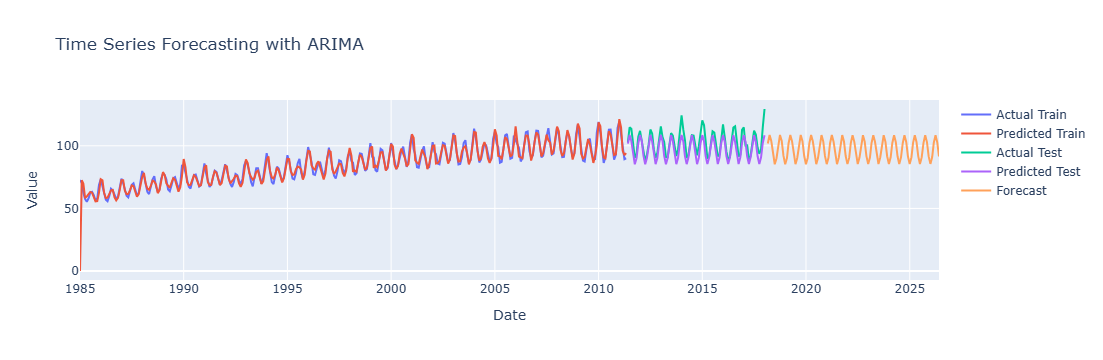

In [290]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train['Value'], mode='lines', name='Actual Train'))
fig.add_trace(go.Scatter(x=train.index, y=train_pred, mode='lines', name='Predicted Train'))
fig.add_trace(go.Scatter(x=test.index, y=test['Value'], mode='lines', name='Actual Test'))
fig.add_trace(go.Scatter(x=test.index, y=test_pred, mode='lines', name='Predicted Test'))
fig.add_trace(go.Scatter(x=forecast_index, y=forecast, mode='lines', name='Forecast'))
fig.update_layout(
    title='Time Series Forecasting with ARIMA',
    xaxis_title='Date',
    yaxis_title='Value'
)

fig.show()

### Prophet Model

In [291]:
df = pd.read_csv('simple.csv')
df.rename(columns={'DATE': 'ds', 'Value': 'y'}, inplace=True)

In [292]:
df.head()

,ds,y
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502
3,04-01-1985,57.4714
4,05-01-1985,55.3151


In [293]:
df['ds'] = pd.to_datetime(df['ds'])

In [294]:
# Split the data into training and test sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

In [302]:
model = Prophet()
fit = model.fit(train_df)

06:28:50 - cmdstanpy - INFO - Chain [1] start processing
06:28:50 - cmdstanpy - INFO - Chain [1] done processing


In [296]:
forecast = model.predict(df)
y_train_pred = forecast['yhat'][:train_size]
y_test_pred = forecast['yhat'][train_size:]

In [297]:
# Evaluate the model
y_true = test_df['y'].values
y_pred = forecast['yhat'].iloc[-len(test_df):].values
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MAE: 3.488775049153413
RMSE: 4.405398269517121


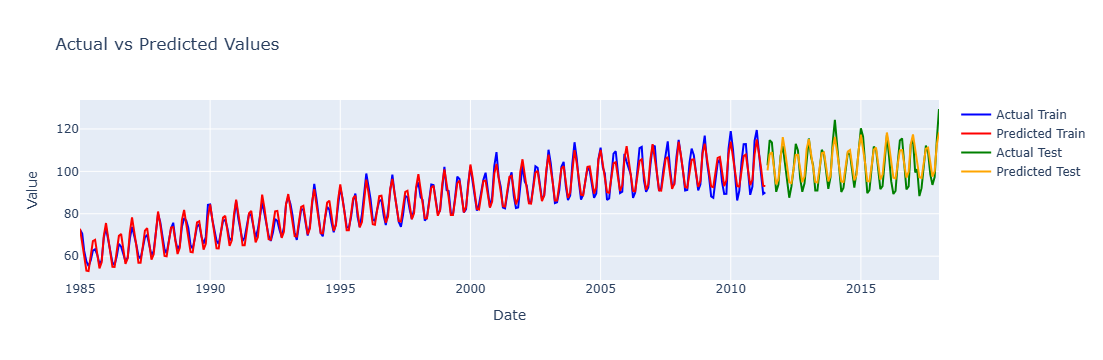

In [298]:
fig_actual_vs_predicted = go.Figure()
fig_actual_vs_predicted.add_trace(go.Scatter(x=train_df['ds'], y=train_df['y'], mode='lines', name='Actual Train', line=dict(color='blue')))
fig_actual_vs_predicted.add_trace(go.Scatter(x=train_df['ds'], y=y_train_pred, mode='lines', name='Predicted Train', line=dict(color='red')))
fig_actual_vs_predicted.add_trace(go.Scatter(x=test_df['ds'], y=test_df['y'], mode='lines', name='Actual Test', line=dict(color='green')))
fig_actual_vs_predicted.add_trace(go.Scatter(x=test_df['ds'], y=y_test_pred, mode='lines', name='Predicted Test', line=dict(color='orange')))

fig_actual_vs_predicted.update_layout(title='Actual vs Predicted Values',
                                      xaxis_title='Date',
                                      yaxis_title='Value')

fig_actual_vs_predicted.show()